# Price Optimization Simulations
### finding optimum individual prices with multi-arm contextual bandit policies

In [1]:
import jax
import numpy as np
import pandas as pd

# Low level operators
from jax import lax

# API for working with pseudorandom number generators
from jax import random

# Numpy API with hardware acceleration and automatic differentiation
from jax import numpy as jnp

# Creates a function that evaluates the gradient of fun.
from jax import grad

# multi arm bandit base aglorithms 
from base_algorithms import action_value_init, action_value_update, beta_init, beta_update, exp3_init, exp3_update, simulate_salesdata

# visualizations
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Random seed to make our experiment replicable 
SEED = 142

# hyperparamter for EXP3 algorith (must be defined globally)
GAMMA_EXP3 = 0.01

# Number of visitors (attempted deals) we want to simulate
NUM_VISITS = 5000

# Possible prices which can be offered to client (prices normalized to range (0,1 ))
PRICE_LIST = jnp.arange(0,1,0.01)

# Featurs differentiating client groups of different price sensitivity (i.e., the context)
FEATURE_SPACE = jnp.asarray([jnp.asarray([0,1]), jnp.asarray([1,0])], dtype=jnp.float32)

# Price Sensitivity Parameters for Client Groups, these parameters are used to determine 
# clients stochastic behavior
PRICE_SENSITIVITY_PARMS = jnp.asarray([[0.3,0.05], [0.5,0.1]])

## Price Sensitivity Model

The following curve can be interpreted as a depiction of the likelihood of a given client closing a deal. There are two client groups (orange and blue) with different price sensitivities. Prices range between 0 and 1. 

Each point in the diagram is the average percentage clients who will accept a deal at price x. The blue client group is more price sensitive.

Each client has a stochastic price threshhold (the threshold is normally distributed with mean and standard deviation being fixed per client group). The client accepts the deal if the price falls below this threshhold.

In [23]:
# simulate sales
ds = simulate_salesdata(
    N = 100000,
    features = FEATURE_SPACE,
    price_list = PRICE_LIST,
    price_sensitivity_parms = PRICE_SENSITIVITY_PARMS,
    seed = 12
)

# aggregate and calculate avereage win rate
df = pd.DataFrame(columns=["f1", "f2", "p", "d"])
df["f1"] = ds[0]
df["f2"] = ds[1]
df["p"] = ds[2]
df["d"] = ds[3]
df2 = df.groupby(['f1', 'f2', 'p'])['d'].mean().reset_index()

In [24]:
df2.to_csv('simulated_data.csv')

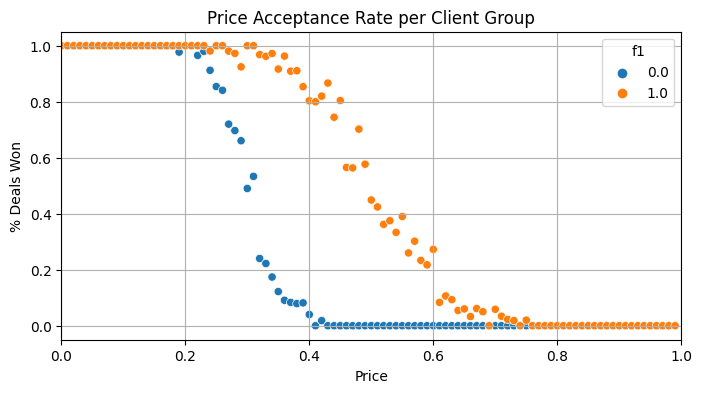

In [4]:
FS = (8, 4)  # figure size
r = jnp.linspace(0, 1, 200)
_, ax = plt.subplots(figsize=FS)

sns.scatterplot(data=df2, x="p", y="d", hue= "f1")

ax.grid()
_ = ax.set(xlabel="Price", ylabel="% Deals Won", title="Price Acceptance Rate per Client Group")
_ = ax.set_xlim(0, 1)

The scatterplot above approximates the curve defined by:
    $$1 - CDF(\mu, \sigma)$$
Where CDF denotes the cumuative distribution function of the normal distribution.

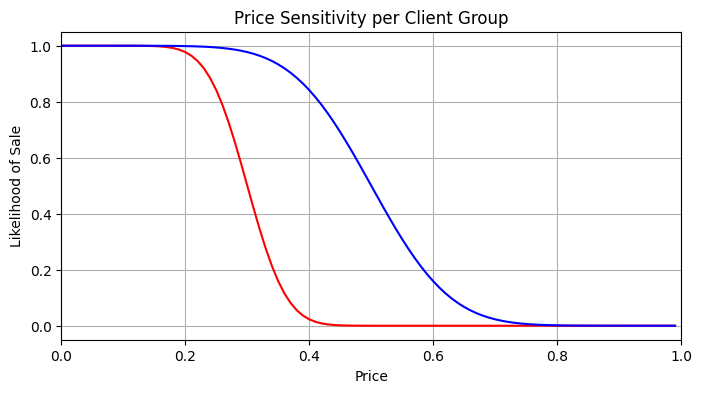

In [5]:
# lambda x: norm.cdf(x, x.mean(), x.std())
from scipy.stats import norm
PRICE_SENSITIVITY_PARMS = jnp.asarray([[0.3,0.05], [0.5,0.1]])

p1 = 1 - jax.scipy.stats.norm.cdf(PRICE_LIST, PRICE_SENSITIVITY_PARMS[0][0], PRICE_SENSITIVITY_PARMS[0][1])
exp_return1 = (1 - jax.scipy.stats.norm.cdf(PRICE_LIST, PRICE_SENSITIVITY_PARMS[0][0], PRICE_SENSITIVITY_PARMS[0][1]))*PRICE_LIST

p2 = 1 - jax.scipy.stats.norm.cdf(PRICE_LIST, PRICE_SENSITIVITY_PARMS[1][0], PRICE_SENSITIVITY_PARMS[1][1])
exp_return2 = (1 - jax.scipy.stats.norm.cdf(PRICE_LIST, PRICE_SENSITIVITY_PARMS[1][0], PRICE_SENSITIVITY_PARMS[1][1]))*PRICE_LIST

FS = (8, 4)  # figure size
r = jnp.linspace(0, 1, 200)
_, ax = plt.subplots(figsize=FS)
plt.plot(PRICE_LIST, p1, 'r-')
plt.plot(PRICE_LIST, p2, 'b-')

ax.grid()
_ = ax.set(xlabel="Price", ylabel="Likelihood of Sale", title="Price Sensitivity per Client Group")
_ = ax.set_xlim(0, 1)

In [6]:
# # idea to simulate adversarial bandit
# PRICE_SENSITIVITY_PARMS_A = jnp.asarray([[0.3,0.05], [0.5,0.1]])
# PRICE_SENSITIVITY_PARMS_B = jnp.asarray([[0.1,0.05], [0.3,0.1]])

# mu1 = jnp.arange(0,1,0.001)
# mu2 = jnp.arange(1,0,-0.001)
# mu = jnp.append(mu1, mu2)
# timestep = 50
# (1-mu[timestep])*PRICE_SENSITIVITY_PARMS_A[0] + mu[timestep]*PRICE_SENSITIVITY_PARMS_B[0]

### Optimal Price

The price which we optimize for is the price with the highest expected return, i.e. $$ max \mathbb{E}[reward] = argmax_{price} [ price* \mathbb{P}(deal_{price}) ]$$
The plot below depicts the expected return per price and client group and marks the optimal with a vertical line.

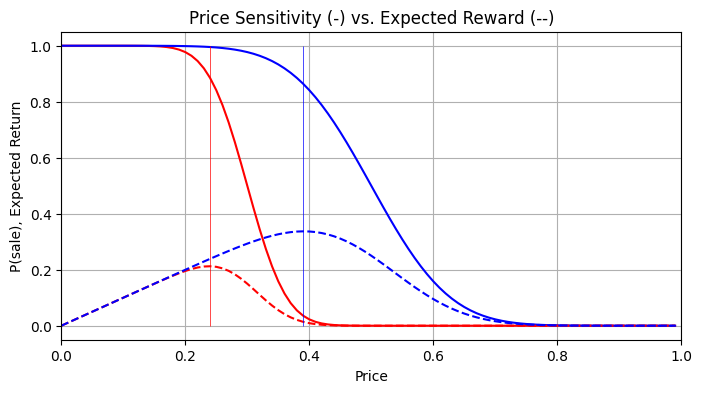

In [7]:
# lambda x: norm.cdf(x, x.mean(), x.std())
from scipy.stats import norm
PRICE_SENSITIVITY_PARMS = [[0.3,0.05], [0.5,0.1]]

p1 = 1 - jax.scipy.stats.norm.cdf(PRICE_LIST, PRICE_SENSITIVITY_PARMS[0][0], PRICE_SENSITIVITY_PARMS[0][1])
exp_return1 = (1 - jax.scipy.stats.norm.cdf(PRICE_LIST, PRICE_SENSITIVITY_PARMS[0][0], PRICE_SENSITIVITY_PARMS[0][1]))*PRICE_LIST

p2 = 1 - jax.scipy.stats.norm.cdf(PRICE_LIST, PRICE_SENSITIVITY_PARMS[1][0], PRICE_SENSITIVITY_PARMS[1][1])
exp_return2 = (1 - jax.scipy.stats.norm.cdf(PRICE_LIST, PRICE_SENSITIVITY_PARMS[1][0], PRICE_SENSITIVITY_PARMS[1][1]))*PRICE_LIST

FS = (8, 4)  # figure size
r = jnp.linspace(0, 1, 200)
_, ax = plt.subplots(figsize=FS)
plt.plot(PRICE_LIST, p1, 'r-')
plt.plot(PRICE_LIST, p2, 'b-')
plt.plot(PRICE_LIST, exp_return1, 'r--')
plt.plot(PRICE_LIST, exp_return2, 'b--')
ax.vlines(x=PRICE_LIST[jnp.argmax(exp_return1)], ymin = 0., ymax =1., colors= 'r', lw=0.5)
ax.vlines(x=PRICE_LIST[jnp.argmax(exp_return2)], ymin = 0., ymax =1., colors = 'b', lw=0.5)

ax.grid()
_ = ax.set(xlabel="Price", ylabel="P(sale), Expected Return", title="Price Sensitivity (-) vs. Expected Reward (--)")
_ = ax.set_xlim(0, 1)

## Simulation of Online Price Optimization

In [8]:
def visit(state, timestep, feature_list, price_list, price_sensitivity_params, policy_fn, update_fn):
    """
    Simulates a user visit.
    """

    # Unpacking the experiment state into
    # the agent's parameters and the random number generator
    params, beta_params, exp3_params, rng = state

    # Splitting the random number generator
    next_rng, client_group_rng, policy_rng, user_rng = random.split(rng, num=4)

    # simulate client type
    client_group = jnp.asarray(random.randint(client_group_rng, shape=[1], minval = 0, maxval = feature_list.shape[0]))[0]
    
    # Selecting the variant to show the user, based on
    # the given policy, the agent's paramters, and the current timestep
    price = policy_fn(params, beta_params, exp3_params, feature_list[client_group], client_group, price_sensitivity_params[client_group], price_list, timestep, policy_rng)

    # Calculate Optimal Price
    exp_reward = (1 - jax.scipy.stats.norm.cdf(price_list, price_sensitivity_params[client_group][0], price_sensitivity_params[client_group][1]))*reward(price_list)
    optimal_price = price_list[jnp.argmax(exp_reward)]
    
    # Calyculate regret
    regret = jnp.abs(optimal_price - price)
    # Randomly simulating a deal based on price senisivity parameters
    random_normal = random.normal(user_rng)
    client_price_limit = price_sensitivity_params[client_group][0] + price_sensitivity_params[client_group][1] * random_normal
    sold = client_price_limit >= price

    # Calculating the agent's updated parameters, based on
    # the current parameters, the price that was offered,
    # and whether or not the client accepted
    next_params = action_value_update(feature_list[client_group], price_list, client_group, params, price, sold)
    next_beta_params = beta_update(feature_list[client_group], price_list, client_group, beta_params, price, sold)
    next_exp3_params = exp3_update(feature_list[client_group], price_list, client_group, exp3_params, price, sold, gamma=GAMMA_EXP3)
    
    # Returning the updated experiment state (params and rng) and details of the deal
    return (next_params, next_beta_params, next_exp3_params, next_rng), (price, sold, regret)

### Implementing the Pricing Policies

See white paper for a discription of multi-arm contextual bandits and the ppolicies defined below.

All bease-algorithms implement **cross-over learning**, i.e.

- if a deal is lost at price p, lost deals are simulated for all prices >p, ceteris paribus
- if a deal is won at price p, won deals are simulated for all prices <p, ceteris paribus

In [9]:
def reward(price):
    # turnover/profit genrated from sale
    return price

In [10]:
def epsilon_greedy_policy(params, beta_params, exp3_params, features, client_group, price_sensitivity_params, price_list, timestep, rng, epsilon = 0.1):
    """
    Randomly selects either the variant with highest action-value,
    or an arbitrary variant.
    """

    # Selecting a random variant
    def explore(params, client_group, price_list, rng):
        i = random.choice(rng, jnp.arange(len(price_list)))
        return price_list[i]
    
        # Selecting the variant with the highest action-value estimate
    def exploit(params, client_group, price_list, rng):
        # maximum expected reward
        (n_dict, q_dict) = params
        exp_reward = q_dict[client_group]*price_list
        argmax = price_list[jnp.argmax(exp_reward)]
        return argmax

    
    # Splitting the random number generator 
    uniform_rng, choice_rng = random.split(rng)
    
    # Deciding randomly whether to explore or to exploit
    return lax.cond(
        random.uniform(uniform_rng) < epsilon,
        explore,
        exploit,
        params, 
        client_group, 
        price_list,
        choice_rng
    )

In [11]:
def optimal_policy(params, beta_params, exp3_params, features, client_group, price_sensitivity_params, price_list, timestep, rng):
    """
    Policy always selects price with max expected return. It is merely a benchmark.
    """
    
    exp_reward = (1 - jax.scipy.stats.norm.cdf(price_list, price_sensitivity_params[0], price_sensitivity_params[1]))*reward(price_list)
    optimal_price = price_list[jnp.argmax(exp_reward)]
    
    return optimal_price

In [12]:
def thompson_policy(params, beta_params, exp3_params, features, client_group, price_sensitivity_params, price_list, timestep, rng):
    """
    Thompson sampling by drawing from conjugate prior beta distribution
    """
    
    a, b = beta_params
    price = price_list[jnp.argmax(random.beta(rng, a[client_group], b[client_group])*reward(price_list))]

    return price

In [13]:
def upper_confidence_bound_policy(params, beta_params, exp3_params, features, client_group, price_sensitivity_params, price_list, timestep, rng, confidence = 2):
    """
    Selects the price with highest action-value plus upper confidence bound
    """

    # Read n and q parameters
    (n_dict, q_dict) = params
    ucb_exp_reward = (q_dict[client_group] + confidence * jnp.sqrt(jnp.log(timestep) / n_dict[client_group]))*reward(price_list)
    
    # Calculating each variant's upper confidence bound
    # and selecting the variant with the highest value
    return price_list[jnp.argmax(ucb_exp_reward)]

In [14]:
def exp3_policy(params, beta_params, exp3_params, features, client_group, price_sensitivity_params, price_list, timestep, rng, gamma= 0.01):
    """
    Selects the price with highest expected return according to EXP3 algorithm
    """

    # Read parameters
    w = exp3_params[client_group]
    # calculate the p distribtion 
    p_exp3 = (1-gamma)*w/jnp.sum(w) + gamma/len(price_list)
    
    # and selecting the variant with the highest value
    return random.choice(
        rng,
        jnp.arange(len(price_list)),
        p=jax.nn.softmax(p_exp3)
        )

## Implementing the evaluation

In [15]:
from functools import partial
from matplotlib import pyplot as plt

In [16]:
def evaluate(policy_fn, init_fn, update_fn):
    """
    Simulating the experiment for NUM_VISITS users
    while accumulating the click history
    """

    return lax.scan(
        # Compiling the visit function using just-in-time (JIT) compilation
        # for better performance
        jax.jit(
            # Partially applying the visit function by fixing
            # the price list, feature space, price sensitivity, policy_fn, and update_fn parameters 
            partial(
                visit,
                feature_list=jnp.array(FEATURE_SPACE),
                price_list=jnp.array(PRICE_LIST),
                price_sensitivity_params=jnp.array(PRICE_SENSITIVITY_PARMS),
                policy_fn=jax.jit(policy_fn),
                update_fn=jax.jit(update_fn)
            )
        ),
        
        # Initialising the experiment state using
        # init_fn 
        (init_fn(FEATURE_SPACE, PRICE_LIST), 
        # initialize beta distribution parameters
         beta_init(FEATURE_SPACE, PRICE_LIST),
        # initialize EXP3 algorith parameters
         exp3_init(FEATURE_SPACE, PRICE_LIST),
         
        # and a new PRNG key 
         random.PRNGKey(SEED)),
        
        # Setting the number steps of the experiment
         jnp.arange(1, NUM_VISITS + 1)
    )

In [17]:
def reward_evolution(history):
    """
    Calculates the regret for every action in the experiment history
    """

    # Calculating regret with regard to picking the optimal (0.045) variant
    def fn(acc, reward):
        n, v = acc[0] + 1, acc[1] + reward
        return (n, v), (v / n)
    
    # Calculating regret values over entire history
    _, reward = lax.scan(
        jax.jit(fn),
        (jnp.array(0), jnp.array(0)),
        history[0]*history[1]
    )
    
    return reward

In [18]:
def regret_evolution(history):
    """
    Calculates the regret for every action in the experiment history
    """

    # Calculating regret with regard to picking the optimal (0.045) variant
    def fn(acc, regret):
        n, r = acc[0] + 1, acc[1] + regret
        return (n, r), (r / n)
    
    # Calculating regret values over entire history
    _, regret = lax.scan(
        jax.jit(fn),
        (jnp.array(0), jnp.array(0)),
        history[2]
    )
    
    return regret

In [19]:
# Epsilon greedy policy
(epsilon_greedy_params, epsilon_greedy_beta_params, epsilon_greedy_exp3_params, _), (epsilon_greedy_history) = evaluate(
    policy_fn=partial(epsilon_greedy_policy, epsilon=0.1),
    init_fn=action_value_init,
    update_fn=action_value_update
)

# Thompson sampling policy
(thompson_params, thompson_beta_params, thompson_exp3_params, _), (thompson_history) = evaluate(
    policy_fn=partial(thompson_policy),
    init_fn=action_value_init,
    update_fn=action_value_update
)

# Optimal policy
(optimal_params, optimal_beta_params, optimal_exp3_params, _), optimal_history = evaluate(
    policy_fn=partial(optimal_policy),
    init_fn=action_value_init,
    update_fn=action_value_update
)

# Optimal policy
(ucb_params, ucb_beta_params, ucb_exp3_params, _), ucb_history = evaluate(
    policy_fn=partial(upper_confidence_bound_policy, confidence=1),
    init_fn=action_value_init,
    update_fn=action_value_update
)

# EXP3 policy
(exp3_params, exp3_beta_params, exp3_exp3_params, _), exp3_history = evaluate(
    policy_fn=partial(exp3_policy, gamma=GAMMA_EXP3),
    init_fn=action_value_init,
    update_fn=action_value_update
)

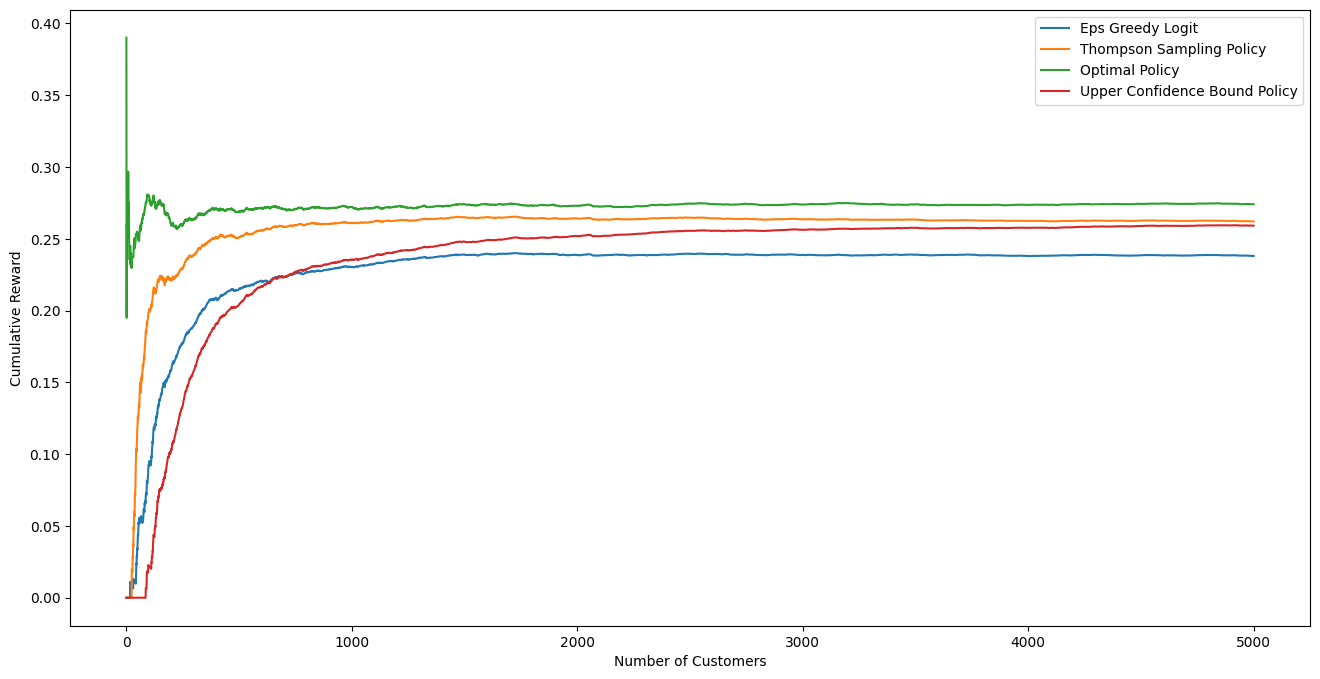

In [20]:
# Visualisation
fig, ax = plt.subplots(figsize=(16, 8))

x = jnp.arange(1, NUM_VISITS + 1)

ax.set_xlabel('Number of Customers')
ax.set_ylabel('Cumulative Reward')

ax.plot(x, reward_evolution(epsilon_greedy_history), label='Eps Greedy Logit')
ax.plot(x, reward_evolution(thompson_history), label='Thompson Sampling Policy')
ax.plot(x, reward_evolution(optimal_history), label='Optimal Policy')
ax.plot(x, reward_evolution(ucb_history), label='Upper Confidence Bound Policy')
#ax.plot(x, reward_evolution(exp3_history), label='EXP3 Policy')

plt.legend()
plt.show()

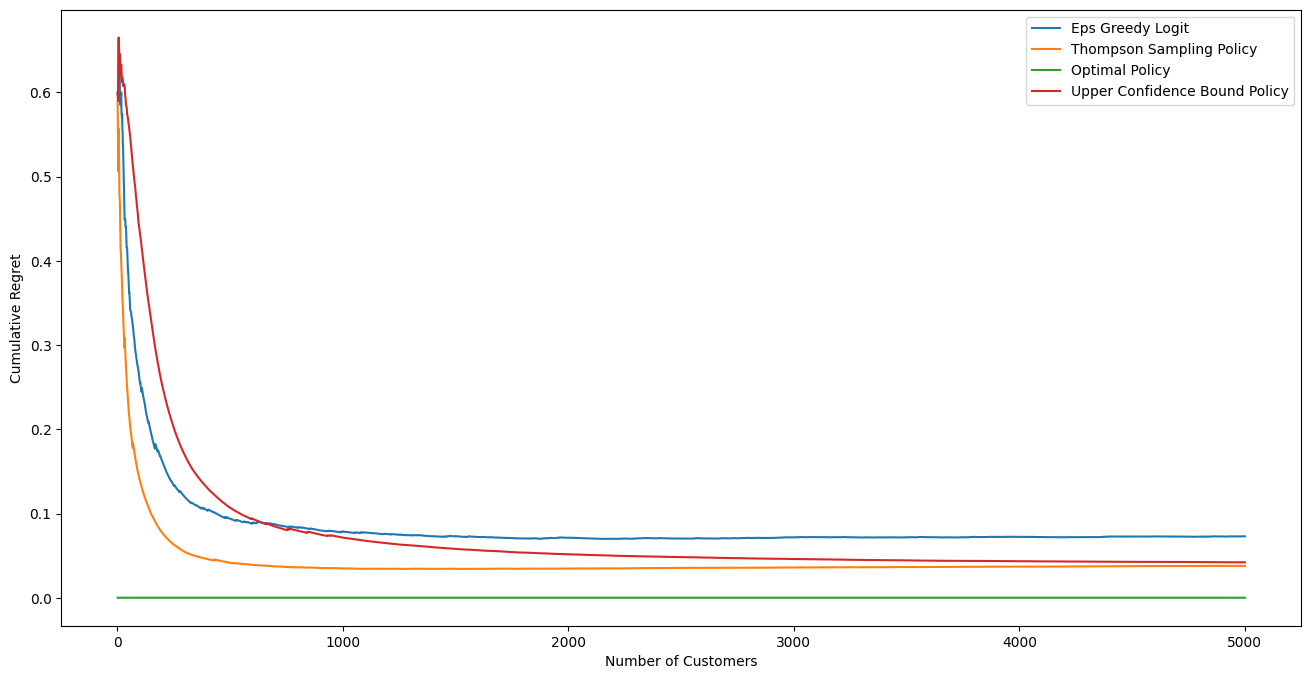

In [21]:
# Visualisation
fig, ax = plt.subplots(figsize=(16, 8))

x = jnp.arange(1, NUM_VISITS + 1)

ax.set_xlabel('Number of Customers')
ax.set_ylabel('Cumulative Regret')

ax.plot(x, regret_evolution(epsilon_greedy_history), label='Eps Greedy Logit')
ax.plot(x, regret_evolution(thompson_history), label='Thompson Sampling Policy')
ax.plot(x, regret_evolution(optimal_history), label='Optimal Policy')
ax.plot(x, regret_evolution(ucb_history), label='Upper Confidence Bound Policy')
#ax.plot(x, regret_evolution(exp3_history), label='EXP3 Policy')

plt.legend()
plt.show()